---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| hide
import numpy as np
from budget_optimizer.optimizer import *
from budget_optimizer.utils.model_classes import *
import scipy.optimize as opt
import matplotlib.pyplot as plt

# budget_optimizer

> Budget optimizer for nested MMMs

This library is to help wrap custom models for use in budget optimization. It is designed to work with nested MMMs, where the budget is allocated to different media channels and the performance is measured by multiple KPIs which are fed into a downstream revenue model. 

For example in a typical MMM, the budget is allocated to different media channels and the performance is measured by sales, website visits, and brand awareness. Website visits and brand awareness impact sales, website visits are impacted by brand awareness. So the effects of changing the budget flow through the nested KPIs.

The library is designed to work with any model that can be wrapped in a `Model` class. The `Model` class should have needs a `predict` method that takes a dictionary of parameters and returns an xarray dataset with the model prediction for that model's kpi. These model classes can be composed in a `NestedModel` class which will flow the predictions into the next stage of the model.

Model loading and functions to define how budget translates into model inputs must be defined in a seperate file. Included in the folder with the model artifacts in a file called `model_config.py` which should contain the following functions:

- `model_loader` - a function that takes a path and returns a `Model` object
- `budget_to_model_inputs` - a function that a budget and model object and returns a dataset of model inputs

:::{.callout-note collapse="True"}

## How to define the model_config.py file

See the example in the `example_files` folder for an example of how to define these functions for a simple model.
:::

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install budget_optimizer in Development mode

```sh
# make sure budget_optimizer package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to budget_optimizer
$ nbdev_prepare
```

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/redam94/budget_optimizer.git
```


or from [pypi][pypi]


```sh
$ pip install budget_optimizer
```


[repo]: https://github.com/redam94/budget_optimizer
[docs]: https://redam94.github.io/budget_optimizer/
[pypi]: https://pypi.org/project/budget_optimizer/
[conda]: https://anaconda.org/redam94/budget_optimizer

### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs]. Additionally you can find package manager specific guidelines on [conda][conda] and [pypi][pypi] respectively.

[repo]: https://github.com/redam94/budget_optimizer
[docs]: https://redam94.github.io/budget_optimizer/
[pypi]: https://pypi.org/project/budget_optimizer/
[conda]: https://anaconda.org/redam94/budget_optimizer

## How to use

#### Step 1: Create a model_config.py file

This contains the functions to load the model and convert the budget into model inputs. This allows models to be updated without changing the code in the budget_optimizer library.

```{.python}
## file: example_files/model_1/model_config.py
import xarray as xr
from pathlib import Path
import numpy as np
from budget_optimizer.utils.model_helpers import AbstractModel, BudgetType

INITIAL_BUDGET: BudgetType = dict(a=2., b=3.)

class SimpleModel(AbstractModel):
  """
  Simple model that just adds the two variables a and b.
  This can be as complex as you want as long as it has a predict method
  that takes an xarray Dataset and returns an xarray DataArray and 
  a contributions method that takes an xarray Dataset and returns an xarray Dataset.
  
  Ideally, the model should also have data that defines the initial data that the
  model was trained on. You can wrap cutom models or functions in a class like this.
  """
  def __init__(self, data: xr.Dataset = None):
    self.data = data
    
  def predict(self, x: xr.Dataset) -> xr.DataArray:
    x = x.copy()
    x["prediction"] = np.exp(1 + .2*(x["a"]**2/(x["a"]**2 + np.exp(1)**2)) + .25*(x["b"]**4/(x["b"]**4 + np.exp(2)**4)))
    return x["prediction"]
  
  def contributions(self, x: xr.Dataset) -> xr.Dataset:
    return x

def budget_to_data(budget: BudgetType, model: AbstractModel) -> xr.Dataset:
    data = model.data.copy()
    for key, value in budget.items():
        data[key] = value/INITIAL_BUDGET[key]*data[key]
    return data
  
def model_loader(path: Path) -> AbstractModel:
    rng = np.random.default_rng(42)
    data_a = xr.DataArray(np.exp(1+rng.normal(0, .4, size=156)), dims='time', coords={"time": np.arange(1, 157)})
    data_b = xr.DataArray(np.exp(2+rng.normal(0, .2, size=156)), dims='time', coords={"time": np.arange(1, 157)})
    return SimpleModel(data = xr.Dataset({"a": data_a, "b": data_b}))
```

#### Step 2: Create a budget model

This is a class that wraps the model and defines how the budget is allocated to the model inputs. It also tracks model names and kpis for future use.

In [ ]:
class RevenueModel(BaseBudgetModel):
    def __init__(self, model_name: str, model_kpi: str, model_path: str):
        super().__init__(model_name, model_kpi, model_path)    

Initialize the model with the path to the model artifacts, model name, and kpi name.

In [ ]:
MODEL_NAME = "Revenue Model"
MODEL_KPI = "Revenue"
MODEL_PATH = "../example_files/model_1"
model = RevenueModel(MODEL_NAME, MODEL_KPI, MODEL_PATH)
budget_1 = dict(a=2, b=3)
budget_2 = dict(a=2.3, b=2.7)
outcome_budget_1 = model.predict(budget_1)
outcome_budget_2 = model.predict(budget_2)

We can now use the model to predict the kpi for a given budget.

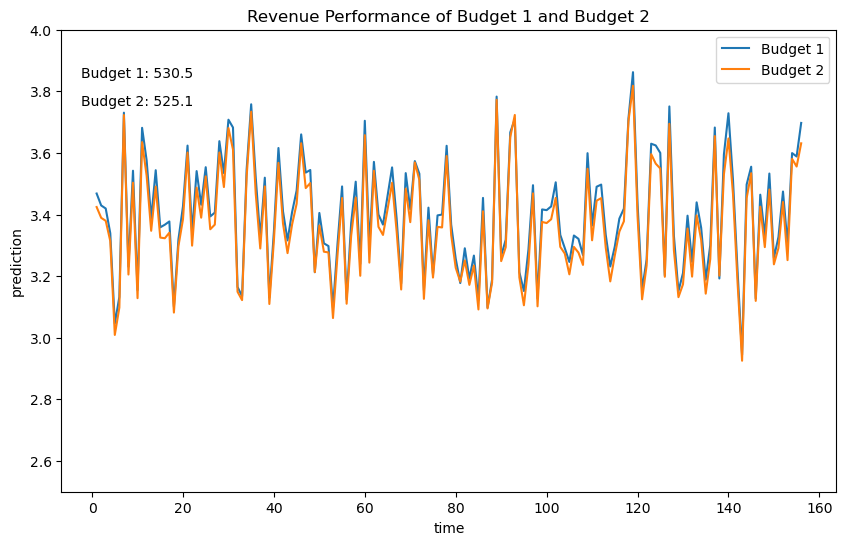

In [ ]:
#| echo: false
#| label: fig-revenue-performance
#| fig-cap: Revenue Performance of Budget 1 and Budget 2
plt.figure(figsize=(10, 6))
outcome_budget_1.plot(label="Budget 1")
outcome_budget_2.plot(label="Budget 2")
plt.title("Revenue Performance of Budget 1 and Budget 2")
plt.annotate(
  f"Budget 1: {outcome_budget_1.sum().values:0.1f}", 
  (10, 3.8), textcoords="offset points", 
  xytext=(0,10), ha='center')
plt.annotate(
  f"Budget 2: {outcome_budget_2.sum().values:0.1f}", 
  (10, 3.8), textcoords="offset points", 
  xytext=(0,-10), ha='center')
plt.ylim(2.5, 4)
plt.legend();

#### Step 3: Create the Optimizer Config Files

This is a file that defines the loss function for the optimization problem. It should contain a function named `loss_fn` that takes the predriction from the model and kwargs and returns a scalar loss to minimize.

```{.python}
## file: example_files/optimizer_config.py
import numpy as np
import xarray as xr

def loss_fn(x: xr.DataArray, start_date=None, end_date=None, dim="Period"):
    # start_date and end_date are datetime objects
    # return a scalar loss
    x = x.sel({dim: slice(start_date, end_date)})
    return -np.sum(x)
```

An additional file will be used define the kwargs for the loss function and the initial budget.

```{.yaml}
initial_budget:
  a: 2
  b: 3
loss_fn_kwargs:
  start_date: null
  end_date: null
  dim: "time"
```

#### Step 4: Create the Optimizer

Instantiate the optimizer and define the initial position, bounds and constraints for the optimization problem.

In [ ]:
init_budget = np.array([2, 3])
bounds = [(1.7, 2.3), (2.7, 3.3)]
constraints = opt.LinearConstraint([[1, 1]], [5], [5])
optimizer = Optimizer(model, "../example_files")

#### Step 5: Run the optimization

In [ ]:
fitted_optimizer = optimizer.optimize(init_budget, bounds, constraints)

In [ ]:
fitted_optimizer.optimal_budget

{'a': np.float64(1.8000836826100175), 'b': np.float64(3.1999163173899827)}

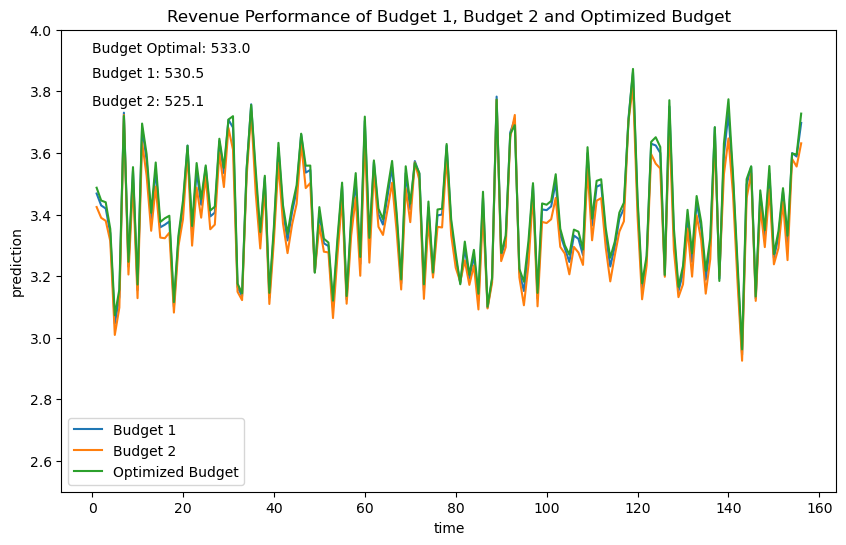

In [ ]:
#| echo: false
#| label: fig-revenue-performance-optimized
#| fig-cap: Revenue Performance of Budget 1 and Budget 2
plt.figure(figsize=(10, 6))
outcome_budget_1.plot(label="Budget 1")
outcome_budget_2.plot(label="Budget 2")
fitted_optimizer.optimal_prediction.plot(label="Optimized Budget")
plt.title("Revenue Performance of Budget 1, Budget 2 and Optimized Budget")
plt.annotate(
  f"Budget 1: {outcome_budget_1.sum().values:0.1f}", 
  (0, 3.8), textcoords="offset points", 
  xytext=(0,10), ha='left')
plt.annotate(
  f"Budget 2: {outcome_budget_2.sum().values:0.1f}", 
  (0, 3.8), textcoords="offset points", 
  xytext=(0,-10), ha='left')
plt.annotate(
  f"Budget Optimal: {fitted_optimizer.optimal_prediction.sum().values:0.1f}", 
  (0, 3.8), textcoords="offset points", 
  xytext=(0,28), ha='left')
plt.ylim(2.5, 4)
plt.legend();